# 1. Setup and get Data

## 1.1 Install Dependencies and Setup

In [1]:
pip install labelme tensorflow opencv-python matplotlib albumentations

Note: you may need to restart the kernel to use updated packages.


## 1.2 Collect Data with OpenCV

In [1]:
import os
import time
import uuid
import cv2

In [2]:
IMAGES_PATH = os.path.join('data', 'images')
number_images = 30 #take 90 images in total

In [6]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting Image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH, f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

## 1.3 Annotate Images with LabelMe

In [7]:
!labelme

# 2. Review Data and Build Image Loading Function

## 2.1 Import TF and Deps

In [4]:
import tensorflow as tf
import cv2
import json
import numpy as np
from matplotlib import pyplot as plt

2023-05-07 13:09:49.767434: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 2.2 Limit GPU Memory Growth

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
tf.config.list_physical_devices('GPU')

[]

## 2.3 Load Images into TF Data Pipeline

In [7]:
images = tf.data.Dataset.list_files('data/images/*.jpg', shuffle=False)

2023-03-22 21:55:19.368374: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


InvalidArgumentError: Expected 'tf.Tensor(False, shape=(), dtype=bool)' to be true. Summarized data: b'No files matched pattern: data/images/*.jpg'

In [4]:
def load_image(x):
        byte_img = tf.io.read_file(x)
        img = tf.io.decode_jpeg(byte_img)
        return img

In [35]:
images = images.map(load_image)

In [36]:
images.as_numpy_iterator().next()

array([[[137, 130, 122],
        [137, 130, 122],
        [138, 129, 122],
        ...,
        [123, 121, 108],
        [121, 117, 105],
        [120, 116, 104]],

       [[136, 129, 121],
        [136, 129, 121],
        [137, 128, 121],
        ...,
        [121, 119, 106],
        [119, 115, 103],
        [119, 115, 103]],

       [[136, 129, 121],
        [136, 129, 121],
        [136, 129, 121],
        ...,
        [118, 116, 103],
        [117, 115, 102],
        [116, 114, 101]],

       ...,

       [[ 68,  46,  33],
        [ 66,  44,  31],
        [ 66,  42,  30],
        ...,
        [ 49,  43,  43],
        [ 58,  49,  50],
        [ 60,  51,  52]],

       [[ 69,  47,  34],
        [ 67,  45,  32],
        [ 65,  43,  30],
        ...,
        [ 49,  40,  41],
        [ 57,  49,  47],
        [ 59,  51,  49]],

       [[ 69,  47,  34],
        [ 67,  45,  32],
        [ 65,  43,  30],
        ...,
        [ 48,  39,  40],
        [ 56,  48,  46],
        [ 59,  51,  49]]

## 2.4 View Raw Images with MatPlotLib

In [39]:
image_generator = images.batch(4).as_numpy_iterator()

In [43]:
plot_images = image_generator.next()

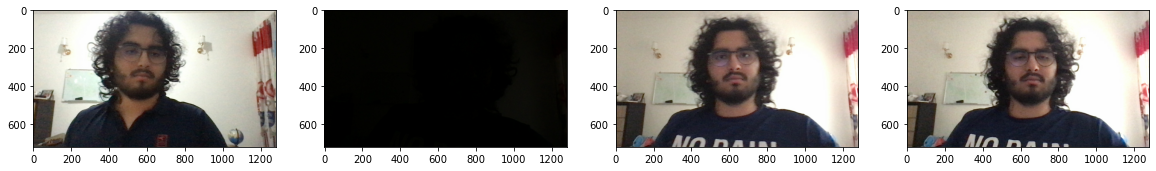

In [44]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()

# 3. Partition Unaugmented Data

## 3.1 MANUALLY SPLIT DATA INTO TRAIN, TEST AND VAL

## 3.2 Move the matching labels

In [46]:
# for folder in ['train', 'test', 'val']:
#     for file in os.listdir(os.path.join('data', folder, 'images')):
#         filename = file.split('.')[0] + '.json'
#         existing_filepath = os.path.join('data', 'labels', filename)
#         if os.path.exists(existing_filepath):
#             new_filepath = os.path.join('data', folder, 'labels', filename)
#             os.replace(existing_filepath , new_filepath)

# 4. Apply Image Augmentations on Images and Labels using Albumentations

## 4.1 Setup Albumentations Tramsform Pipeline

In [47]:
import albumentations as alb

In [53]:
augment = alb.Compose([alb.RandomCrop(width=700, height=700),
                      alb.HorizontalFlip(p=0.5),
                      alb.RandomBrightnessContrast(p=0.2),
                      alb.RandomGamma(p=0.2),
                      alb.RGBShift(p=0.2),
                      alb.VerticalFlip(p=0.5)],
                     bbox_params=alb.BboxParams(format='albumentations', label_fields=['class_labels']))

## 4.2 Load a Test Image and Annotation with OpenCV and JSON

In [54]:
img = cv2.imread(os.path.join('data', 'train', 'images', '9d6b07c8-c62b-11ed-b3fc-acde48001122.jpg'))

In [58]:
with open(os.path.join('data', 'train', 'labels', '9d6b07c8-c62b-11ed-b3fc-acde48001122.json'), 'r') as f:
    label = json.load(f)

In [62]:
label['shapes'][0]['points']

[[461.2765957446809, 90.85106382978728], [791.063829787234, 490.8510638297873]]

## 4.3 Extract Coordinates and Rescale to Match Image Resolution

In [63]:
coords = [0, 0, 0, 0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [66]:
coords = list(np.divide(coords, [1280, 720, 1280, 720]))

In [67]:
coords

[0.36037234042553196,
 0.12618203309692677,
 0.6180186170212766,
 0.6817375886524824]

## 4.4 Apply Augmentations

In [69]:
augmented = augment(image=img, bboxes=[coords], class_labels=['face'])

In [71]:
augmented.keys()

dict_keys(['image', 'bboxes', 'class_labels'])

In [73]:
augmented['image'].shape

(700, 700, 3)

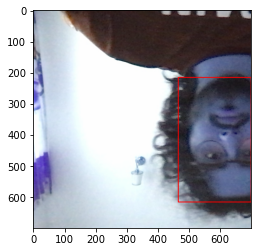

In [74]:
cv2.rectangle(augmented['image'],
             tuple(np.multiply(augmented['bboxes'][0][:2], [700, 700]).astype(int)),
             tuple(np.multiply(augmented['bboxes'][0][2:], [700, 700]).astype(int)),
             (255,0,0), 2)
plt.imshow(augmented['image'])

# 5. Build and Run Augmentation Pipeline

## 5.1 Run Augmentation Pipeline

In [77]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [1280, 720, 1280, 720]))

        try: 
            for x in range(60):
                augmented = augment(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

image must be numpy array type
image must be numpy array type
image must be numpy array type


## Check that the augmented images have correct bounding boxes

In [87]:
img = cv2.imread(os.path.join('aug_data', 'train', 'images', '9d6b07c8-c62b-11ed-b3fc-acde48001122.37.jpg'))
with open(os.path.join('aug_data', 'train', 'labels', '9d6b07c8-c62b-11ed-b3fc-acde48001122.37.json'), 'r') as f:
    label = json.load(f)
label['bbox']

[0.6403951367781155, 0.32021276595744674, 1.0, 0.8916413373860181]

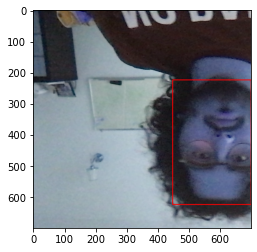

In [88]:
cv2.rectangle(img,
             tuple(np.multiply(label['bbox'][:2], [700, 700]).astype(int)),
             tuple(np.multiply(label['bbox'][2:], [700, 700]).astype(int)),
             (255,0,0), 2)
plt.imshow(img)

## 5.2 Load Augmented Images into Tensorflow Dataset

In [5]:
train_images = tf.data.Dataset.list_files('aug_data/train/images/*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120, 120)))
train_images = train_images.map(lambda x: x/225)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2023-04-25 12:27:56.481305: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
test_images = tf.data.Dataset.list_files('aug_data/test/images/*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120, 120)))
test_images = test_images.map(lambda x: x/225)

In [7]:
val_images = tf.data.Dataset.list_files('aug_data/val/images/*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120, 120)))
val_images = val_images.map(lambda x: x/225)

In [8]:
val_images.as_numpy_iterator().next()

array([[[0.7385494 , 0.7163272 , 0.6318827 ],
        [0.7373148 , 0.7150926 , 0.63064814],
        [0.74333334, 0.7211111 , 0.63666666],
        ...,
        [1.0955555 , 1.0555555 , 0.9888888 ],
        [1.0966667 , 1.0655556 , 0.99444443],
        [1.0985494 , 1.0674382 , 0.9874382 ]],

       [[0.75175923, 0.7117592 , 0.64509255],
        [0.75222224, 0.7122222 , 0.64555556],
        [0.7525    , 0.7125    , 0.6458333 ],
        ...,
        [1.0977777 , 1.0711111 , 1.        ],
        [1.0977777 , 1.0711111 , 1.        ],
        [1.0988889 , 1.0766667 , 0.99222225]],

       [[0.7442901 , 0.6958642 , 0.61570984],
        [0.7642592 , 0.7112037 , 0.64      ],
        [0.7425617 , 0.68922836, 0.6181173 ],
        ...,
        [1.0940431 , 1.062932  , 0.9918209 ],
        [1.1114814 , 1.0892593 , 1.0048147 ],
        [1.1066667 , 1.08      , 1.0088888 ]],

       ...,

       [[0.2388887 , 0.43444428, 0.55444425],
        [0.21777777, 0.41777778, 0.52      ],
        [0.2458644 , 0

# 6. Prepare Labels

## 6.1 Build Label Loading Function

In [9]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
    return [label['class']], label['bbox']

## 6.2 Load Labels to Tensorflow Dataset

In [10]:
train_labels = tf.data.Dataset.list_files('aug_data/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [11]:
test_labels = tf.data.Dataset.list_files('aug_data/test/labels/*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [12]:
val_labels = tf.data.Dataset.list_files('aug_data/val/labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [13]:
val_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.4692 , 0.08813, 0.9067 , 0.687  ], dtype=float16))

# 7. Combine Label and Image Samples

## 7.1 Check Partition Lengths

In [14]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels),

(3840, 3840, 840, 840, 780, 780)

## 7.2 Create Final Datasets

In [15]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [16]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [17]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

## 7.3 View Images and Annotations

In [18]:
samples = train.as_numpy_iterator()

In [19]:
res = samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


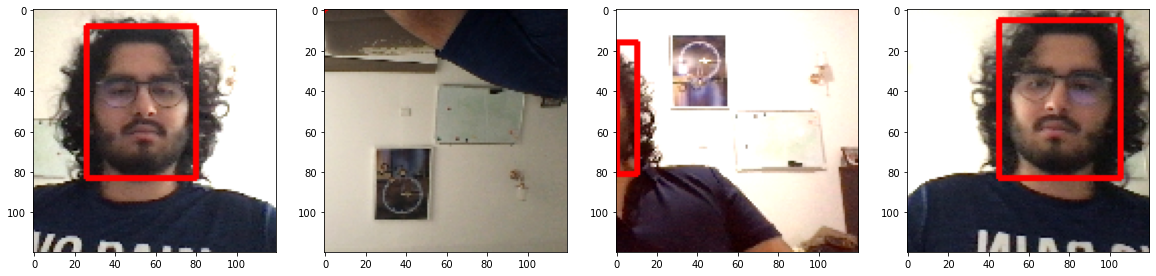

In [20]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx in range(4):
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    cv2.rectangle(sample_image,
             tuple(np.multiply(sample_coords[:2], [120, 120]).astype(int)),
             tuple(np.multiply(sample_coords[2:], [120, 120]).astype(int)),
             (255,0,0), 2)
    ax[idx].imshow(sample_image)

# 8. Build Deep Learning Model with Functional API

## 8.1 Import Layers and Base Network

In [21]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

## 8.2 Download VGG16

In [22]:
vgg = VGG16(include_top=False)

In [23]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

## 8.3 Build Instance of Network

In [38]:
def build_model():
    input_layer = Input(shape=(120, 120, 3))
    
    vgg = VGG16(include_top=False)(input_layer)
    
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

## 8.4 Test Out Neural Network

In [39]:
facetracker = build_model()

In [40]:
facetracker.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_4[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d_2 (Global  (None, 512)         0           ['vgg16[0][0]']                  
 MaxPooling2D)                                                                              

In [41]:
X, y = train.as_numpy_iterator().next()

In [42]:
X.shape

(8, 120, 120, 3)

In [43]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 0s 273ms/step


In [44]:
classes, coords

(array([[0.59131575],
        [0.603037  ],
        [0.5382067 ],
        [0.6097819 ],
        [0.6040494 ],
        [0.55265695],
        [0.5261931 ],
        [0.51525503]], dtype=float32),
 array([[0.4956378 , 0.59957355, 0.5613202 , 0.4557844 ],
        [0.47644997, 0.6380736 , 0.63719743, 0.5293351 ],
        [0.48194283, 0.64763135, 0.63270605, 0.4398714 ],
        [0.51038253, 0.6344356 , 0.6369053 , 0.51939   ],
        [0.45447057, 0.6532297 , 0.63506263, 0.51044244],
        [0.43223765, 0.6737155 , 0.6469607 , 0.4219009 ],
        [0.30166873, 0.66453785, 0.6790377 , 0.5118064 ],
        [0.4837184 , 0.5985448 , 0.55757356, 0.44052616]], dtype=float32))

In [45]:
y

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.4792 , 0.     , 1.     , 0.724  ],
        [0.1028 , 0.309  , 0.6284 , 0.899  ],
        [0.4153 , 0.04987, 0.8984 , 0.667  ],
        [0.11725, 0.3867 , 0.6035 , 0.937  ],
        [0.     , 0.1409 , 0.3574 , 0.691  ],
        [0.     , 0.04776, 0.3335 , 0.7256 ],
        [0.     , 0.02791, 0.1583 , 0.6816 ],
        [0.1989 , 0.03094, 0.801  , 0.7393 ]], dtype=float16))

# 9. Define Losses and Optimizers

## 9.1 Define Optimizer and LR

In [47]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 - 1)/batches_per_epoch

In [6]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

2023-05-07 13:22:19.608212: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 9.2 Create Localization (Regression) Loss and Classification Loss

In [50]:
def localization_loss(y, yhat):
    delta_coord = tf.reduce_sum(tf.square(y[:,:2] - yhat[:, :2]))
    
    h = y[:, 3] - y[:, 1]
    w = y[:, 2] - y[:, 0]
    
    h_hat = yhat[:, 3] - yhat[:, 1]
    w_hat = yhat[:, 2] - yhat[:, 0]
    
    delta_size = tf.reduce_sum(tf.square(w - w_hat) + tf.square(h - h_hat))
    
    return delta_coord + delta_size

In [52]:
classloss = tf.keras.losses.BinaryCrossentropy()
regloss = localization_loss

## 9.3 Test Out Loss Metrics

In [54]:
localization_loss(y[1], coords).numpy()

9.19435

In [64]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.5684555>

In [65]:
regloss(y[1], coords).numpy()

9.19435

# 10. Train Neural Network

## 10.1 Create Custom Model Class

In [86]:
class FaceTracker(Model):
    def __init__(self, facetracker, **kwargs):
        super().__init__(**kwargs)
        self.model = facetracker
    
    def compile(self, opt, classloss, regloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.rloss = regloss
        self.opt = opt
        
    def train_step(self, batch, **kwargs):
        X, y = batch
        
        with tf.GradientTape() as tape:
            classes, coords = self.model(X, training=True)
            
            batch_closs = self.closs(tf.cast(y[0], tf.float32), classes)
            batch_rloss = self.rloss(tf.cast(y[1], tf.float32), coords)
            total_loss = batch_rloss + 0.5 * batch_closs
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
            
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss": total_loss, "batch_classloss": batch_closs, "batch_regloss": batch_rloss}
    
    def test_step(self, batch, **kwargs):
        X, y = batch
    
        classes, coords = self.model(X, training=True)
            
        batch_closs = self.closs(tf.cast(y[0], tf.float32), classes)
        batch_rloss = self.rloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_rloss + 0.5 * batch_closs
        
        return {"total_loss": total_loss, "batch_classloss": batch_closs, "batch_regloss": batch_rloss}
    
    def call(self, X, **kwargs):
        return self.model(X, **kwargs)

In [87]:
model = FaceTracker(facetracker)

In [88]:
model.compile(opt, classloss, regloss)

## 10.2 Train Model

In [89]:
logdir= 'logs'

In [90]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [91]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
480/480 [==============================] - 449s 925ms/step - total_loss: 0.3257 - batch_classloss: 0.0802 - batch_regloss: 0.2856 - val_total_loss: 0.0514 - val_batch_classloss: 8.7131e-04 - val_batch_regloss: 0.0510
Epoch 2/10
480/480 [==============================] - 459s 951ms/step - total_loss: 0.1183 - batch_classloss: 0.0335 - batch_regloss: 0.1015 - val_total_loss: 0.1126 - val_batch_classloss: 6.8150e-05 - val_batch_regloss: 0.1125
Epoch 3/10
480/480 [==============================] - 424s 877ms/step - total_loss: 0.1190 - batch_classloss: 0.0334 - batch_regloss: 0.1023 - val_total_loss: 0.0115 - val_batch_classloss: 0.0054 - val_batch_regloss: 0.0088
Epoch 4/10
480/480 [==============================] - 436s 904ms/step - total_loss: 0.0814 - batch_classloss: 0.0254 - batch_regloss: 0.0687 - val_total_loss: 0.0049 - val_batch_classloss: 0.0042 - val_batch_regloss: 0.0028
Epoch 5/10
480/480 [==============================] - 410s 849ms/step - total_loss: 0.0569 - bat

In [92]:
hist.history

{'total_loss': [0.0657227411866188,
  0.19097882509231567,
  0.12152690440416336,
  0.04878460243344307,
  1.8828990459442139,
  0.09245967119932175,
  0.029255198314785957,
  0.018541637808084488,
  0.1302267611026764,
  0.01062067225575447],
 'batch_classloss': [0.003135047387331724,
  8.695287397131324e-05,
  0.001199974911287427,
  0.004477696027606726,
  0.8007024526596069,
  0.009847958572208881,
  0.003850494045764208,
  0.0037015394773334265,
  0.005325745791196823,
  9.171742931357585e-06],
 'batch_regloss': [0.0641552209854126,
  0.19093534350395203,
  0.12092691659927368,
  0.04654575511813164,
  1.4825477600097656,
  0.08753569424152374,
  0.027329951524734497,
  0.016690868884325027,
  0.12756389379501343,
  0.010616086423397064],
 'val_total_loss': [0.0514356903731823,
  0.11255921423435211,
  0.011514401063323021,
  0.004939260892570019,
  0.009220745414495468,
  0.12694939970970154,
  0.000421348144300282,
  0.008535970002412796,
  0.059083711355924606,
  0.003239086130

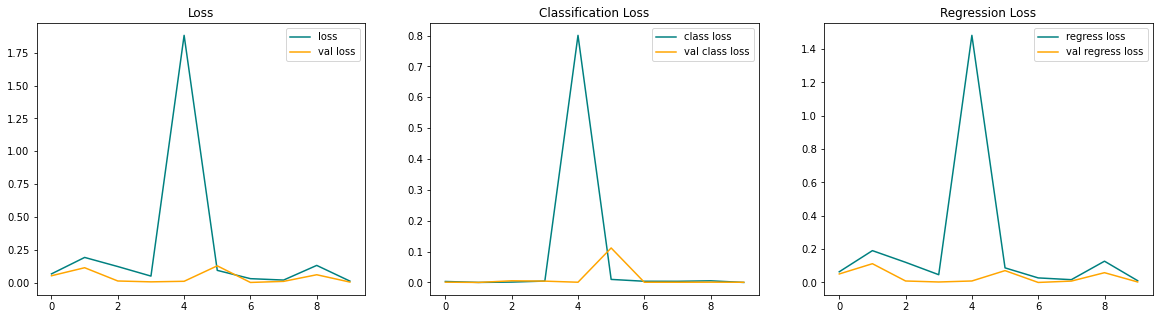

In [94]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['batch_classloss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_batch_classloss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['batch_regloss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_batch_regloss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# 11. Make Predictions

## 11.1 Make Predictions on Test Set

In [30]:
test_data = test.as_numpy_iterator()

In [31]:
test_sample = test_data.next()

In [32]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 338ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


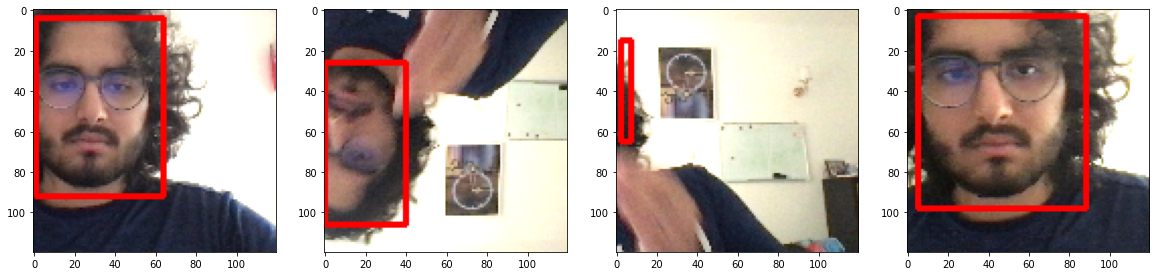

In [33]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx in range(4):
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    cv2.rectangle(sample_image,
             tuple(np.multiply(sample_coords[:2], [120, 120]).astype(int)),
             tuple(np.multiply(sample_coords[2:], [120, 120]).astype(int)),
             (255,0,0), 2)
    ax[idx].imshow(sample_image)

## 11.2 Save the Model

In [28]:
from tensorflow.keras.models import load_model

In [106]:
facetracker.save('facetracker.h5')

In [29]:
facetracker = load_model('facetracker.h5')

## 11.3 Real-time Detection

In [110]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 39ms/step


In [34]:
img = cv2.imread('blah.jpg')
rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
resize = tf.image.resize(rgb, (120, 120))
    
yhat = facetracker.predict(np.expand_dims(resize/255,0))
sample_coords = yhat[1][0]

1/1 [==============================] - 0s 38ms/step


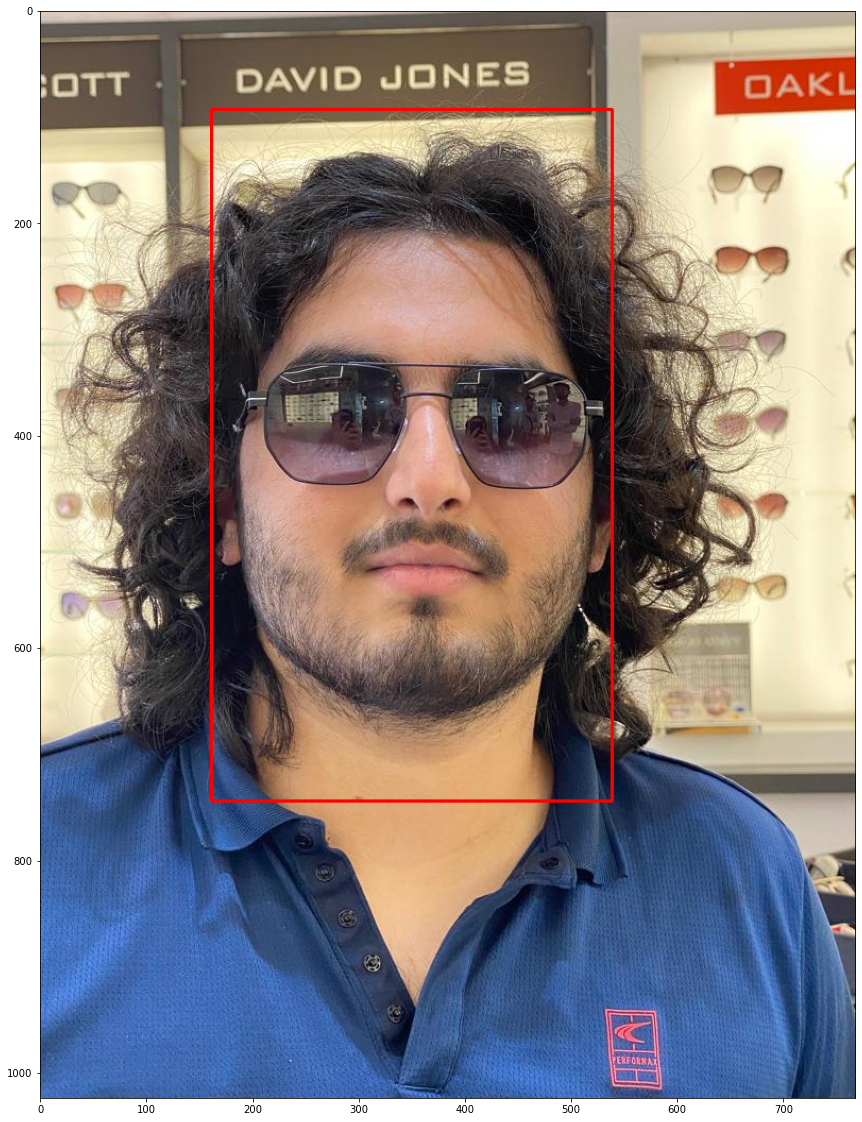

In [35]:
fig, ax = plt.subplots(ncols=1, figsize=(20, 20))
sample_image = rgb
sample_coords = yhat[1][0]
cv2.rectangle(sample_image,
            tuple(np.multiply(sample_coords[:2], [img.shape[1], img.shape[0]]).astype(int)),
            tuple(np.multiply(sample_coords[2:], [img.shape[1], img.shape[0]]).astype(int)),
            (255,0,0), 2)
ax.imshow(sample_image)